# Misc dataset

In [1]:
from model.graph_mcmc import Graph_MCMC

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 22})

In [3]:
graph = Graph_MCMC()
graph.read_from_ns("sp_primary_school/day_2") # escorts could be fun

In [5]:
graph.rename_property("label", "_label")
graph.rename_property("viz", "_viz")

True

In [5]:

graph.convert_props_to_flags()
graph.remove_property("Unknown")

True

In [6]:
graph.list_props()

name                   (graph)   (type: string, val: sp_primary_school (day_2))
description            (graph)   (type: string, val: Two temporal networks of
                                                     contacts among students
                                                     and teachers at a primary
                                                     school in Lyon, France, on
                                                     consecutive days of in
                                                     October 2009. Each network
                                                     accumulates all contacts
                                                     over the course of a
                                                     single day; contacts were
                                                     sampled at 20-second
                                                     intervals)
citation               (graph)   (type: string, val: ['Juliette Stehle et al.,
  

In [7]:
graph.print_info()
graph.partition(B_min=10, B_max=10)

Graph with N=238 nodes, E=5539 edges and D=13 vertex features for training
Performing inference...
Current bracket: (10, 10, 10) (10919.856823723716, 10919.856823723716, 10919.856823723716)
Current bracket: (10, 10, 10) (10919.856823723716, 10919.856823723716, 10919.856823723716)
Bisect at B = 10 with S = 10919.85682372372
Best result: B = 10, S = 10919.85682372372
Done


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f8a797ff190, at 0x7f8a770b07c0>

In [8]:
av_dl = graph.mcmc(num_iter=10000)

100%|██████████| 10000/10000 [00:09<00:00, 1022.63it/s]


Drawing soft partition


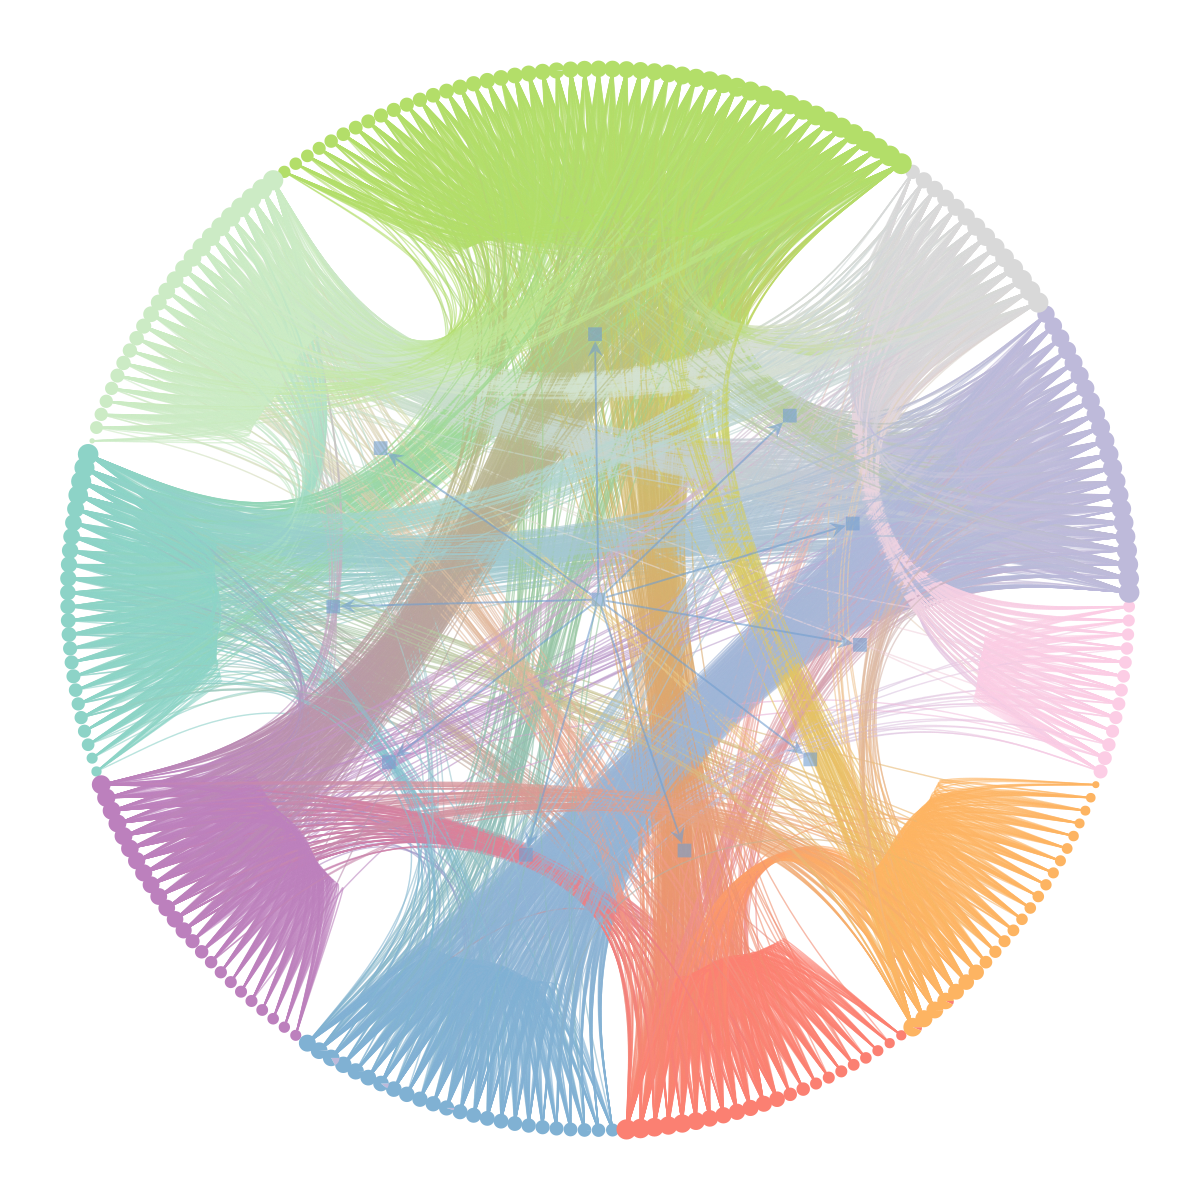

In [9]:
#graph.draw(gen_layout=False, size=10, output="school-graph.png")
graph.draw()

Drawing block adjacency matrix $e_{rs}$


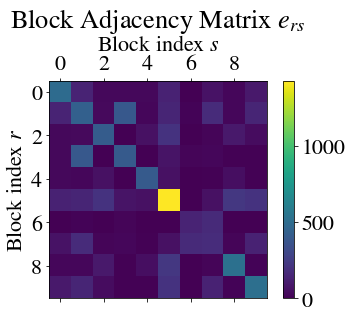

In [10]:
graph.plot_matrix()

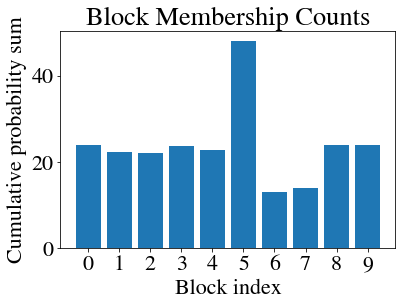

In [11]:
graph.plot_posterior_props()

## Train classifier

In [12]:
from inference.softmax import SoftmaxNeuralNet
import numpy as np

In [13]:
X = graph.generate_feature_matrix()
Y = graph.generate_posterior()

D = X.shape[1]
B = Y.shape[1]

N = X.shape[0]
assert N == Y.shape[0]



In [14]:
from utils.subsampling import random_index_arr

train_indices, test_indices = random_index_arr(N, fraction=0.8)
X_train, Y_train = X[train_indices, :], Y[train_indices, :]
X_test, Y_test = X[test_indices, :], Y[test_indices, :]

In [15]:
classifier = SoftmaxNeuralNet(layers_size=[D, B], sigma=1)
classifier.perform_mala(X_train, Y_train, step_scaling=0.2, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [00:05<00:00, 1774.92it/s]Sample accept ratio: 82.39%
Train. set accuracy: 82.63157894736842%



(0.8239, 0.8263157894736842)

## Interpret results

### Thinning

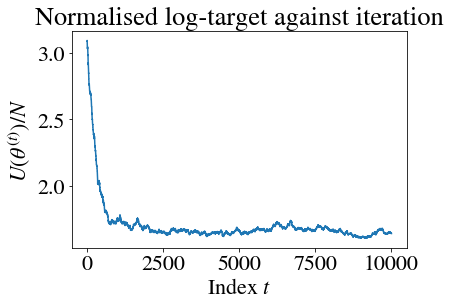

1.7102703302123303

In [16]:
classifier.plot_U()

In [17]:
classifier.thin_samples(burn_in=0.4, thin_factor=10)

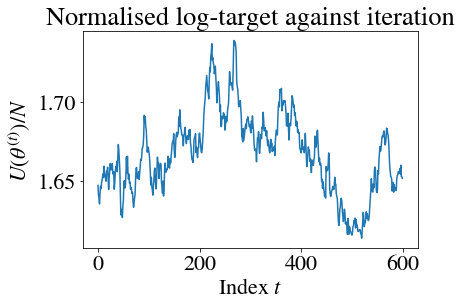

1.6666699538012593


In [18]:
u_mean = classifier.plot_U()
print(u_mean)

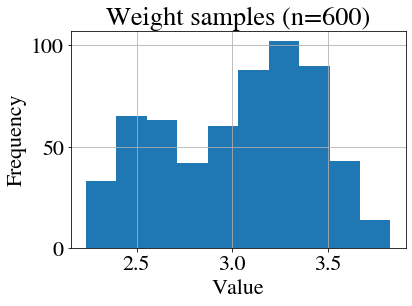

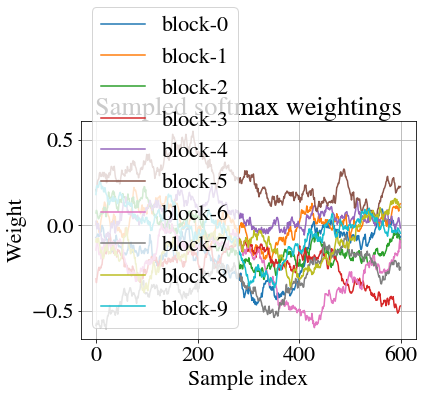

In [19]:
classifier.plot_sample_histogram()
classifier.plot_sample_history()

### Performance

In [20]:
training_loss = classifier.average_loss_per_point(X_train, Y_train, include_prior=False)
test_loss = classifier.average_loss_per_point(X_test, Y_test, include_prior=False)

print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))


Training loss: 0.6855419641961743, Test loss: 0.721899602692435


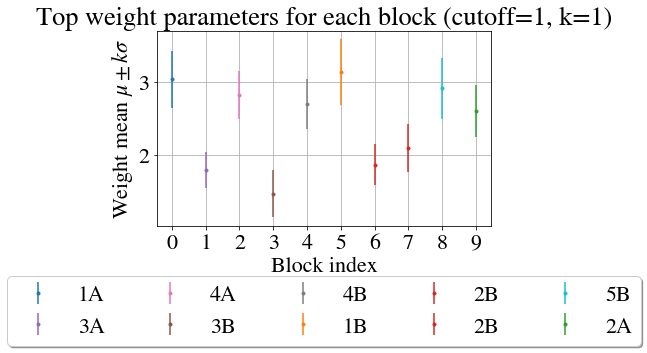

In [21]:
names = list(graph.get_feature_names())
classifier.plot_block_principal_dims(names, cutoff=1, legend=True)

Max cutoff: 1.4566600893840707
Discarded 4 features


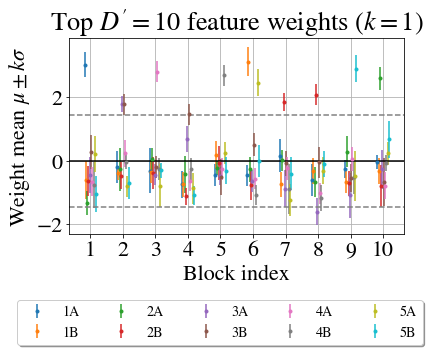

In [22]:
matplotlib.pyplot.rc('legend',fontsize=14)
names = list(graph.get_feature_names())
kept_features = classifier.plot_sampled_weights(names, std_dev_multiplier=1, D_reduced=10, legend=True, ncol=5)

In [23]:
reduced_X_train, reduced_X_test = X_train[:, kept_features], X_test[:, kept_features]

reduced_D = reduced_X_train.shape[1]
B = Y_train.shape[1]

# nwo train new classifier
reduced_classifier = SoftmaxNeuralNet(layers_size=[reduced_D, B], sigma=1)
reduced_classifier.perform_mala(reduced_X_train, Y_train, step_scaling=0.2, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [00:05<00:00, 1859.14it/s]Sample accept ratio: 84.54%
Train. set accuracy: 83.6842105263158%



(0.8454, 0.8368421052631579)

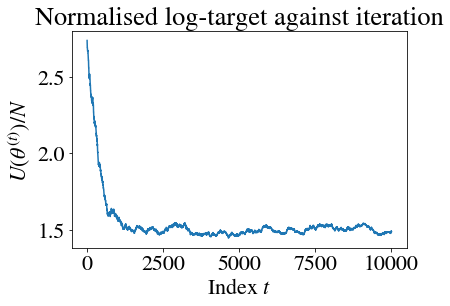

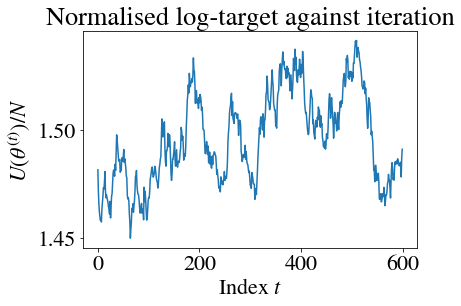

1.4961998764435138

In [24]:
reduced_classifier.plot_U()
reduced_classifier.thin_samples(burn_in=0.4, thin_factor=10)
reduced_classifier.plot_U()

In [25]:
reduced_training_loss = reduced_classifier.average_loss_per_point(reduced_X_train, Y_train, include_prior=False)
reduced_test_loss = reduced_classifier.average_loss_per_point(reduced_X_test, Y_test, include_prior=False)

print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

REDUCED CLASSIFIER -- Training loss: 0.6981693048145301, Test loss: 0.6838633680388605


In [26]:
print("Average description length per entity: {}".format(av_dl))
print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))
print("D': {}".format(len(kept_features)))
print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

Average description length per entity: 1.8890189477060042
Training loss: 0.6855419641961743, Test loss: 0.721899602692435
D': 10
REDUCED CLASSIFIER -- Training loss: 0.6981693048145301, Test loss: 0.6838633680388605
